In [7]:
from data.fetch_data import *
from strategies.alphas import *
import random
from utils.ga_utils import *
import warnings
from utils.optimizer import *
from utils.data_utils import * 

warnings.filterwarnings("ignore")

In [59]:
stock_data = fetch_stock_data("ITC.NS",'2022-08-01','2023-08-08')

[*********************100%%**********************]  1 of 1 completed


In [62]:
def evaluate_strategy(data,delta_lookback=2, correlation_window=6,threshold = 0,stop_loss_percentage = 1):
    data["alpha"] = alpha11(data,delta_lookback, correlation_window)
    data["alpha"] = normalize_alphas(data["alpha"])
    
    data = data.dropna()

    position = 0  # 0 for no position, 1 for long position
    profit = 0
    total_trades = 0
    winning_trades = 0
    stricly_winning_trades = 0
    allocated_funds = 100000
    no_of_shares = 0
    stop_loss_price = 0
    returns = []

    for i in range(1,len(data)):
        try:

            if position == 0:
                if data['alpha'][i] > threshold: 
                
                    position = 1  # Buy (enter long position)
                    entry_price = data['Close'][i]
                    stop_loss_price = entry_price - (entry_price * 0.01 * stop_loss_percentage)
                    # print(f"Entry: {entry_price} on {data.index[i]} Stop Loss: {stop_loss_price}")
                    total_trades += 1
                    no_of_shares = allocated_funds//entry_price
                    

                    
            elif position == 1 :
                
                if data['Close'][i] > entry_price:  # Adjust stop loss only when the price goes up
                    stop_loss_price = max(stop_loss_price, data['Close'][i] - (data['Close'][i] * 0.01 * stop_loss_percentage))
                    
                if data['Low'][i] < stop_loss_price:
                    position = 0  # Sell due to stop loss
                    exit_price = data['Open'][i] if stop_loss_price > data['Open'][i] else stop_loss_price
                    trade_profit = (exit_price - entry_price) * no_of_shares  # Calculate profit/loss
                    profit=trade_profit
                    allocated_funds += profit
                    no_of_shares =0
                    return_on_trade = (exit_price -entry_price) * 100/entry_price
                    returns.append(return_on_trade)
                    # print(f"Exit: {exit_price} on {data.index[i]} exited on stop loss Allocated Funds {allocated_funds}")
                    # print(f"Profit: {profit}")
                    
                    # mask = (results_data['Symbol'] == symbol) & (results_data['Exit_Date'].isnull())
                    # results_data.loc[mask, 'Exit_Date'] = data.index[i]
                    # results_data.loc[mask, 'Exit_Price'] = exit_price
           
                    if(exit_price>= entry_price):
                        winning_trades += 1
                    if(exit_price> entry_price):
                        stricly_winning_trades += 1
                # elif data['MACD_E'][i] < data['Signal_E'][i]:
                #     position = 0  # Sell due to exit condition
                #     exit_price = data['Close'][i]
                #     trade_profit = (exit_price - entry_price) * no_of_shares  # Calculate profit/loss
                #     profit=trade_profit#                     
                #     # print(f"Exit: {exit_price} on {data.index[i]} exited on stop loss Allocated Funds {allocated_funds}")
                #     # print(f"Profit: {profit}")

                #     allocated_funds += profit
                    
                    
                #     # mask = (results_data['Symbol'] == symbol) & (results_data['Exit_Date'].isnull())
                #     # results_data.loc[mask, 'Exit_Date'] = data.index[i]
                #     # results_data.loc[mask, 'Exit_Price'] = exit_price

                #     no_of_shares =0
                #     if(exit_price>= entry_price):
                #         winning_trades += 1
                #     if(exit_price> entry_price):
                #         stricly_winning_trades += 1
            
        except Exception as ex:
            print("Something caused the error",ex)
            break
        win_rate = winning_trades/total_trades if total_trades != 0 else 0

            # Calculate metrics
        metrics = {
            "Profit": profit,
            "Total Trades": total_trades,
            "Winning Trades": winning_trades,
            "Strictly Winning Trades": stricly_winning_trades,
            "Win Rate": win_rate,
            "Allocated Funds": allocated_funds,
            "Sharpe Ratio": calculate_sortino_ratio(pd.Series(returns))
        }

    return metrics
    


In [65]:
# GA: Initialization
def generate_individual():
    
    # Additional parameters for the trading strategy
    param1 = random.randint(2, 20)
    param2 = random.randint(3, 20)
    threshold = random.uniform(0, 1)
    fast_period = random.randint(2,10)
    # slow_period = random.randint(fast_period)
    # slow_p_exit = random.randint(fast_p_exit, 20)
    stop_loss_percentage = random.uniform(-1, 2)
    
    return  [param1,param2,threshold,stop_loss_percentage]





In [66]:
run_ga_optimization(stock_data,generate_individual)

[123164.5275293637, 124308.27876623288, 124507.29749389298, 129386.11970919468]
[124308.27876623288, 124507.29749389298, 129386.11970919468, 129386.11970919468]
[124507.29749389298, 129386.11970919468, 129386.11970919468, 130048.22804259055]
[129386.11970919468, 129386.11970919468, 130048.22804259055, 130455.98637070159]
[129386.11970919468, 130048.22804259055, 130455.98637070159, 130455.98637070159]
[130048.22804259055, 130455.98637070159, 130455.98637070159, 130455.98637070159]
[130455.98637070159, 130455.98637070159, 130455.98637070159, 130455.98637070159]
Saturation condition met, breaking the loop

Best Strategy Metrics (Generation Generation 7):
Profit: -243.95175170898438
Total Trades: 111
Winning Trades: 87
Strictly Winning Trades: 81
Win Rate: 0.7837837837837838
Allocated Funds: 130455.98637070159
Sharpe Ratio: 1.4919913977171293


<AxesSubplot:>

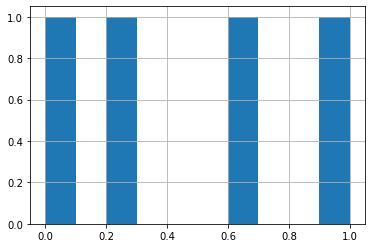

In [24]:
data["alpha"] = alpha11(data,9, 8)
data["alpha"] = normalize_alphas(data["alpha"])
data.alpha.hist()

<AxesSubplot:>

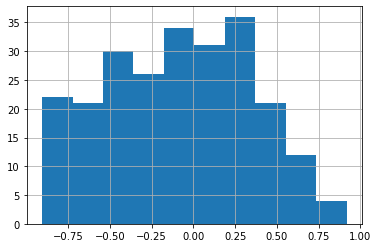

In [ ]:
signal.hist()

In [45]:
pd.Series([1,2,3])<0

0    False
1    False
2    False
dtype: bool

In [21]:
import yfinance as yf
import talib
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Ignore DeprecationWarning
warnings.filterwarnings('ignore', category=FutureWarning) 

# Function to fetch historical stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        return stock_data
    except: 
        print("error in fetching data")
# Function to calculate MACD using TA-Lib
def calculate_macd(data,fast_period,slow_period):
    try:
        if(fast_period > slow_period):
            temp = fast_period
            fast_period = slow_period
            slow_period = temp
        if(fast_period>1):
            macd, signal, _ = talib.MACD(data['Close'], fastperiod=fast_period, slowperiod=slow_period, signalperiod=9)
        else: 
            fast_period = 2 
            macd, signal, _ = talib.MACD(data['Close'], fastperiod=fast_period, slowperiod=slow_period, signalperiod=9)
            
        return macd, signal
    except: 
        print(f"error in calculatin macd signal {fast_period,slow_period}")

In [6]:
data = stock_data

In [40]:
adv20 = data['Volume'].rolling(window=3).mean()
condition = adv20 < data['Volume']
delta_Close_7 = data['Close'].diff(7)
signal = np.where(
    condition,
    -1 * pd.Series(np.abs(delta_Close_7).rolling(window=4).apply(
        lambda x: (x[-1] - np.min(x)) / (np.max(x) - np.min(x)), raw=True
    )).rank() * np.sign(delta_Close_7),
    -1)

<AxesSubplot:>

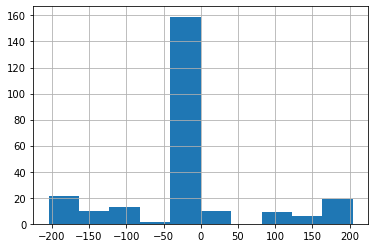

In [43]:
pd.Series(signal).hist()

In [ ]:
import random
from inspect import signature

def generate_individual(alpha_function):
    # Get the parameters accepted by the alpha function
    alpha_params = signature(alpha_function).parameters

    # Define parameter ranges for alpha functions
    parameter_ranges = {
        'param1': (2, 20),
        'param2': (3, 20),
        'threshold': (0, 1),
        'fast_period': (2, 10),
        'stop_loss_percentage': (-1, 2),
        'returns_lookback': (5, 30),
        'power': (1, 5),
        'argmax_window': (3, 10),
        'delta_lookback': (2, 10),
        'correlation_window': (5, 15),
        # Add more parameters as needed for other alpha functions
    }

    # Generate individual with random parameters within specified ranges
    individual = {param: random.uniform(param_range[0], param_range[1]) for param, param_range in parameter_ranges.items() if param in alpha_params}

    return individual

# Example usage
generated_individual_alpha1 = generate_individual(alpha1)
print(generated_individual_alpha1)

generated_individual_alpha2 = generate_individual(alpha2)
print(generated_individual_alpha2)
